In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import IPython.display as ipd
from mutagen.mp3 import MP3

import librosa
import librosa.display
import librosa.effects

import opensmile

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Работа с первым набором признаков. Сохранение в файлы

In [ ]:
def get_mean(file_path): #получаю медиану длины аудио
    sum_lenght = []

    for root, dirs, files in os.walk(file_path):
        for i in files:
            if i == '.DS_Store': continue
                
            path = file_path + i

            sum_lenght.append(MP3(path).info.length)
    
    sum_lenght = np.array(sum_lenght)
    
    return np.mean(sum_lenght), sum_lenght

In [ ]:
def return_target(audio, frame): #функция возвращает таргет для словаря признаков
    data = audio.split('.')[0].split('_')
    
    dia = int(data[0][3:])
    utt = int(data[1][3:])
    
    target = frame[(frame['Dialogue_ID']==dia) & (frame['Utterance_ID']==utt)]['Emotion']
    
    return target[target.index[0]]

In [ ]:
def full_signal(signal, audio_lenght): #функция возвращает обрезанный и сведенный к одной длине сигнал 
    #путем добавления отзеркаливания
    signal_copy = signal.copy()
    reverse_signal = np.flipud(signal_copy)
    
    iters = np.ceil(audio_lenght / len(signal_copy)).astype('int')

    for i in range(iters):
        if i % 2 == 0:
            signal = np.concatenate((signal, reverse_signal), axis=None)

        else: signal = np.concatenate((signal, signal_copy), axis=None)
    
    return signal[:audio_lenght]

In [ ]:
def make_ready_data_audio(direct, frame, audio_lenght, s=22050, drop_broken=False, file_out=None): #основная функция
    len_files = 0
    data = {}
    
    for root, dirs, files in os.walk(direct): #проходимся по всем аудио
        len_files = len(files)
        for i in files:
            if i == '.DS_Store': 
                len_files -= 1
                continue
                
            path = direct + i #директория до аудио
            
            signal, sr = librosa.load(path, sr=s) 
            if (librosa.get_duration(signal, sr) <= 0.5 and drop_broken): 
                len_files -= 1
                continue
                
            signal = signal[:audio_lenght] #обрезка аудио
            
            if(len(signal) < audio_lenght): signal = full_signal(signal, audio_lenght) #если сигнал меньше медианы
                #то на отзеркаливание
            
            
            signal_filt = librosa.effects.preemphasis(signal)#преэмфазис
            
            signal_mel = librosa.feature.melspectrogram(y=signal_filt, sr=sr, n_mels=128,
                                        fmax=8000, hop_length=int(0.01*sr), window='hamming', 
                                                        n_fft=2**(int(np.log2(0.032 * sr)) + 1))
            #мел-спект
            
            target = return_target(i, frame) #запись таргета
            
            data[i] = {'melspectrogram': signal_mel, 'target': target} #итоговый словарь
            
        break
            
    print(f'All data was written? - {len_files == len(data)}')
    
    if file_out is not None: #сохранение данных в файл
        np.save(file_out, data)
    
    return data

In [ ]:
def decoder_npy(path): #достает созданный выше словарь из файла
    data = np.load(path, allow_pickle=True)
    d = dict(enumerate(data.flatten(), 1))
    
    return d[1]

## Проделываем все для train, val, test

In [ ]:
sr = 22050

mean_train, train_lenght = get_mean('data/audio/audio_train/')
audio_lenght = int(round(mean_train,1) * sr)

In [ ]:
audio_lenght 

70560

In [ ]:
train = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/train/train_sent_emo.csv', header=0, sep=',')
train_path = 'data/audio/audio_train/'

train_mels = make_ready_data_audio(direct=train_path, frame=train, audio_lenght=audio_lenght, 
                                   s=sr, file_out='mel_spect/train.npy')

All data was written? - True


In [ ]:
dev = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/dev_sent_emo.csv', header=0, sep=',')
dev_path = 'data/audio/audio_dev/'

dev_mels = make_ready_data_audio(direct=dev_path, frame=dev, audio_lenght=audio_lenght, 
                                   s=sr, file_out='mel_spect/dev.npy')

All data was written? - True


In [ ]:
test = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/test_sent_emo.csv', header=0, sep=',')
test_path = 'data/audio/audio_test/'

test_mels = make_ready_data_audio(direct=test_path, frame=test, audio_lenght=audio_lenght, 
                                   s=sr, file_out='mel_spect/test.npy')

All data was written? - True


# Примеры изменений

## Для короткого аудио
### Чистый звук

In [ ]:
def mel_spect(signal, sr):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128,
                                        fmax=8000, hop_length=int(0.01*sr), window='hamming',
                                                        n_fft=2**(int(np.log2(0.032 * sr)) + 1))
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=sr,
                             fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

    ax.set(title='Mel-frequency spectrogram')
    fig.show()

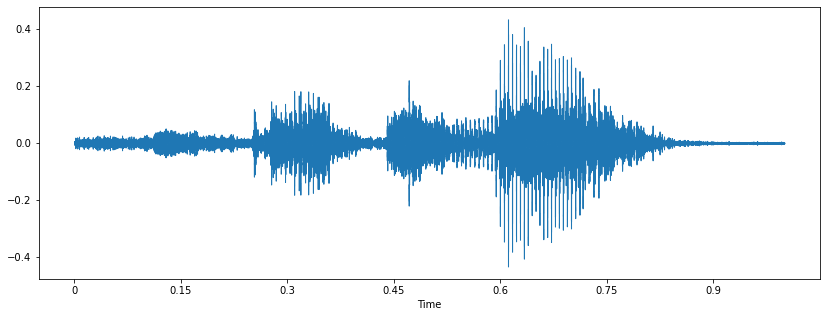

In [ ]:
y, sr = librosa.load('data/audio/audio_train/dia0_utt8.mp3')

player = ipd.Audio(y, rate=sr)
ipd.display(player)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

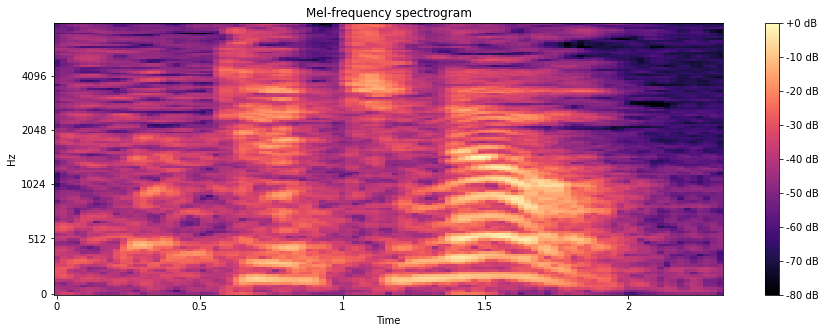

In [ ]:
mel_spect(y, sr)

### Обрезка и отзеркаливание

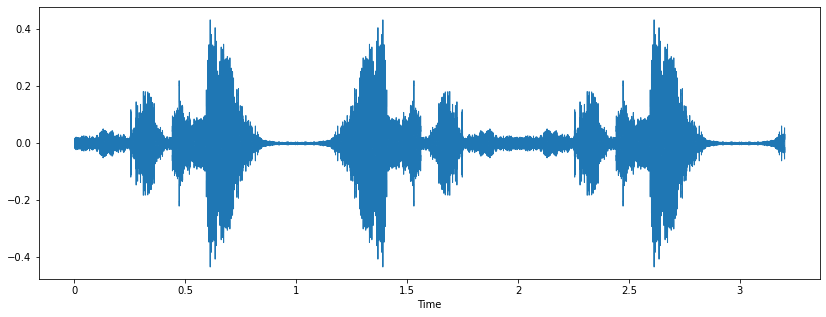

In [ ]:
y = full_signal(y, audio_lenght)

player = ipd.Audio(y, rate=sr)
ipd.display(player)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

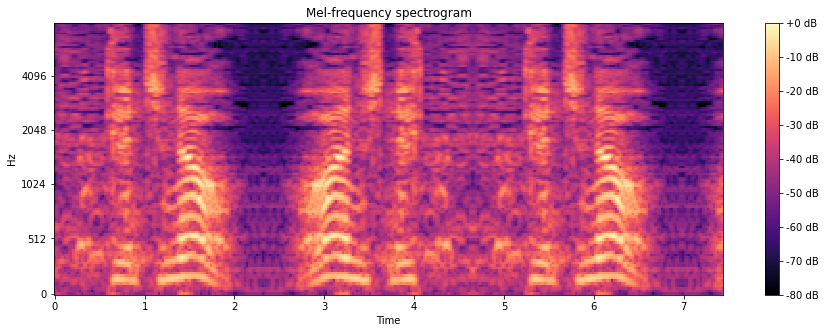

In [ ]:
mel_spect(y, sr)

### Пре-эмфазис

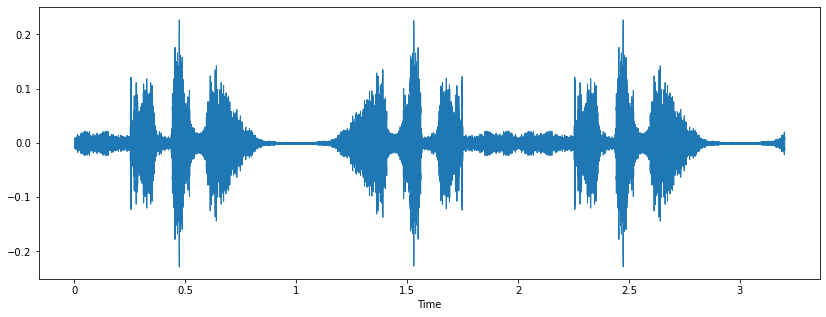

In [ ]:
y = librosa.effects.preemphasis(y)

player = ipd.Audio(y, rate=sr)
ipd.display(player)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

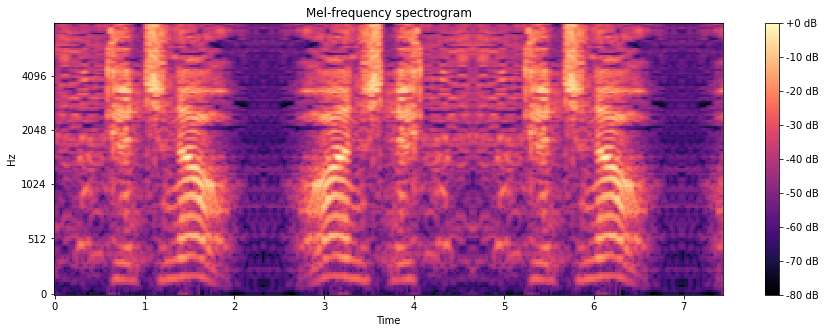

In [ ]:
mel_spect(y, sr)

## Для длинного аудио
### Чистый звук

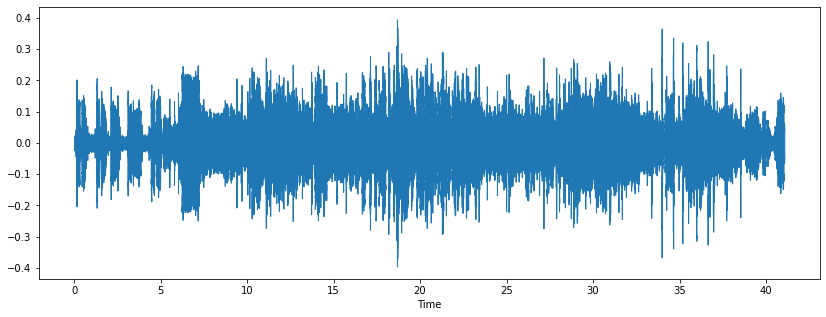

In [ ]:
y, sr = librosa.load('data/audio/audio_train/dia309_utt0.mp3')

player = ipd.Audio(y, rate=sr)
ipd.display(player)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

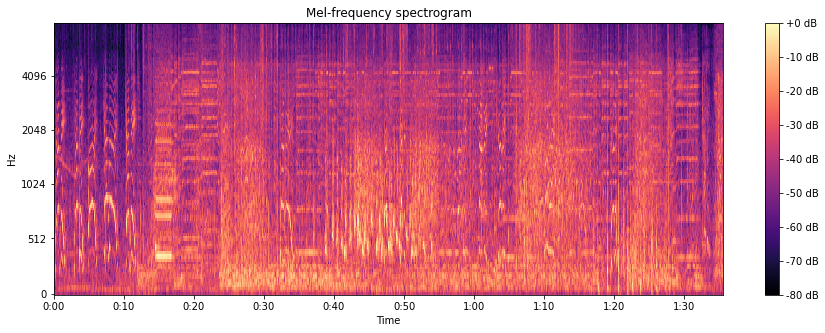

In [ ]:
mel_spect(y, sr)

### Обрезка

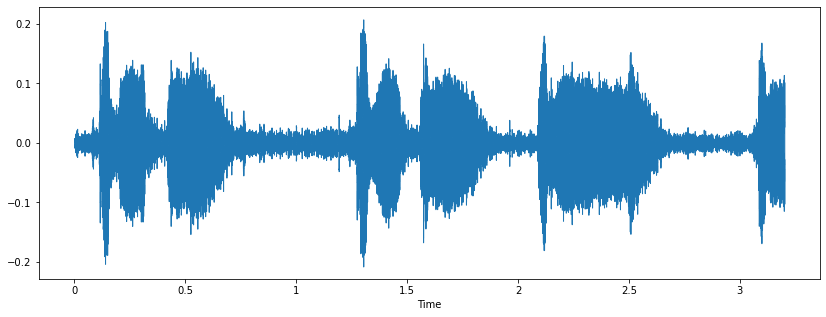

In [ ]:
y = y[:audio_lenght]

player = ipd.Audio(y, rate=sr)
ipd.display(player)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

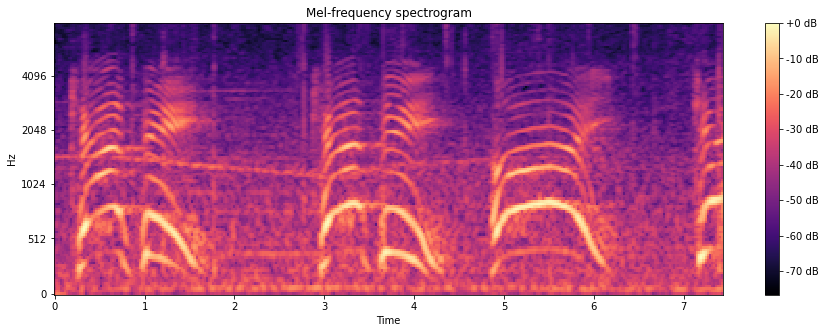

In [ ]:
mel_spect(y, sr)

### Пре-эмфазис

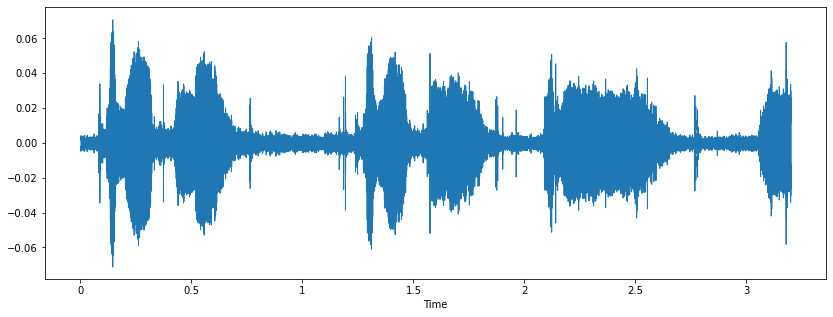

In [ ]:
y = librosa.effects.preemphasis(y)

player = ipd.Audio(y, rate=sr)
ipd.display(player)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

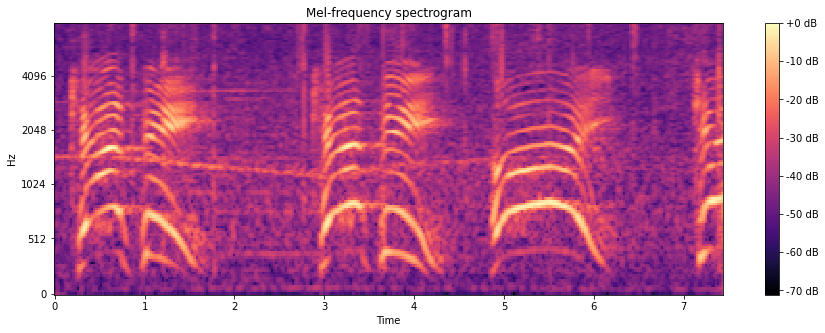

In [ ]:
mel_spect(y, sr)

# OpenSmile
Второй набор признаков

In [ ]:
def make_csv_openSMILE(direct, make_frame, save_path, orig_frame, s, drop_broken=False):
    
    smile = opensmile.Smile()
    music_list = []
    total_targets = []
    
    for root, dirs, files in os.walk(direct): #проходимся по всем аудио
        len_files = len(files)
        for i in files:
            if i == '.DS_Store': 
                len_files -= 1
                continue
                
            path = direct + i #директория до аудио
            
            signal, sr = librosa.load(path, sr=s) 
            
            if (librosa.get_duration(signal, sr) <= 0.5 and drop_broken): 
                len_files -= 1
                continue
            
            frame_audio = smile.process_signal(signal, sr)
            
            target = return_target(i, orig_frame) #запись таргета
            
            music_list.append(i)
            total_targets.append(target)
            
            make_frame = pd.concat([make_frame, frame_audio])
            
        break
    
    make_frame['target'] = total_targets
    make_frame['file'] = music_list
    make_frame.set_index('file', inplace=True)
    
    make_frame.to_csv(save_path)
    
    print(f'All data was saved? - {len_files == make_frame.shape[0]}')
    print(f'All columns are ok? - {6374 == make_frame.shape[1]}')
    
    return make_frame

In [ ]:
sr = 22050

train = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/train/train_sent_emo.csv', header=0, sep=',')
train_path = 'data/audio/audio_train/'
train_SMILE = pd.DataFrame()

train_SMILE = make_csv_openSMILE(train_path, train_SMILE, 'mel_spect/train_openSMILE.csv', train, sr)

All data was saved? - True
All columns are ok? - True


In [ ]:
dev = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/dev_sent_emo.csv', header=0, sep=',')
dev_path = 'data/audio/audio_dev/'
dev_SMILE = pd.DataFrame()

dev_SMILE = make_csv_openSMILE(dev_path, dev_SMILE, 'mel_spect/dev_openSMILE.csv', dev, sr)

All data was saved? - True
All columns are ok? - True


In [ ]:
test = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/test_sent_emo.csv', header=0, sep=',')
test_path = 'data/audio/audio_test/'
test_SMILE = pd.DataFrame()

test_SMILE = make_csv_openSMILE(test_path, test_SMILE, 'mel_spect/test_openSMILE.csv', test, sr)

All data was saved? - True
All columns are ok? - True


In [ ]:
sr = 22050

train = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/train/train_sent_emo.csv', header=0, sep=',')
train_path = 'data/audio/audio_train/'
train_SMILE = pd.DataFrame()

train_SMILE = make_csv_openSMILE(train_path, train_SMILE, 'Features/openSMILE/train_05openSMILE.csv', train, sr,
                                drop_broken=True)

All data was saved? - True
All columns are ok? - True


In [ ]:
dev = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/dev_sent_emo.csv', header=0, sep=',')
dev_path = 'data/audio/audio_dev/'
dev_SMILE = pd.DataFrame()

dev_SMILE = make_csv_openSMILE(dev_path, dev_SMILE, 'Features/openSMILE/dev_05openSMILE.csv', dev, sr,
                                drop_broken=True)

All data was saved? - True
All columns are ok? - True


# Mel-spectrogram
С устраненными дефектными аудиоданными

In [ ]:
train = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/train/train_sent_emo.csv', header=0, sep=',')
train_path = 'data/audio/audio_train/'

train_mels = make_ready_data_audio(direct=train_path, frame=train, audio_lenght=audio_lenght, 
                                   s=sr, drop_broken=True, file_out='Features/mel_spect/train_05.npy')

All data was written? - True


- 'anger' - 1075 / 1109
- 'disgust' - 268 / 271
- 'fear' - 265 / 268
- 'joy' - 1678 / 1743
- 'neutral' - 4568 / 4710
- 'sadness' - 675 / 683
- 'surprise' - 1162 / 1205

In [ ]:
dev = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/dev_sent_emo.csv', header=0, sep=',')
dev_path = 'data/audio/audio_dev/'

dev_mels = make_ready_data_audio(direct=dev_path, frame=dev, audio_lenght=audio_lenght, 
                                   s=sr, drop_broken=True, file_out='Features/mel_spect/dev_05.npy')

All data was written? - True


- 'anger' - 148 / 153
- 'disgust' - 22 / 22
- 'fear' - 37 / 40
- 'joy' - 160 / 163
- 'neutral' - 455 / 469
- 'sadness' - 107 / 111
- 'surprise' - 144 / 150

# MFCC
С устраненными дефектными аудиоданными

In [ ]:
 def get_mfcc_librosa(y, sr, window = 0.032, hop = 0.01, n_mfcc = 12):
        return librosa.feature.mfcc(y=y, sr=sr, hop_length=int(hop*sr), 
                                    n_fft=int(window*sr), n_mfcc=n_mfcc, dct_type=2)

In [ ]:
def get_mfcc(direct, frame, audio_lenght, s=22050, drop_broken=False, file_out=None): #основная функция
    len_files = 0
    data = {}
    
    for root, dirs, files in os.walk(direct): #проходимся по всем аудио
        len_files = len(files)
        for i in files:
            if i == '.DS_Store': 
                len_files -= 1
                continue
                
            path = direct + i #директория до аудио
            
            signal, sr = librosa.load(path, sr=s) 
            if (librosa.get_duration(signal, sr) <= 0.5 and drop_broken): 
                len_files -= 1
                continue
                
            signal = signal[:audio_lenght] #обрезка аудио
            
            if(len(signal) < audio_lenght): signal = full_signal(signal, audio_lenght) #если сигнал меньше медианы
                #то на отзеркаливание
            
            
            signal_filt = librosa.effects.preemphasis(signal)#преэмфазис
            
            signal_mfcc = get_mfcc_librosa(signal_filt, sr)
            
            target = return_target(i, frame) #запись таргета
            
            data[i] = {'melspectrogram': signal_mfcc, 'target': target} #итоговый словарь
            
        break
            
    print(f'All data was written? - {len_files == len(data)}')
    
    if file_out is not None: #сохранение данных в файл
        np.save(file_out, data)
    
    return data

In [ ]:
train = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/train/train_sent_emo.csv', header=0, sep=',')
train_path = 'data/audio/audio_train/'

train_mfcc = get_mfcc(direct=train_path, frame=train, audio_lenght=audio_lenght, 
                                   s=sr, drop_broken=True, file_out='Features/MFCC/train_05mfcc.npy')

All data was written? - True


In [ ]:
dev = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/dev_sent_emo.csv', header=0, sep=',')
dev_path = 'data/audio/audio_dev/'

dev_mfcc = get_mfcc(direct=dev_path, frame=dev, audio_lenght=audio_lenght, 
                                   s=sr, drop_broken=True, file_out='Features/MFCC/dev_05mfcc.npy')

All data was written? - True


In [ ]:
test = pd.read_csv('data/archive/MELD-RAW/MELD.Raw/test_sent_emo.csv', header=0, sep=',')
test_path = 'data/audio/audio_test/'

test_mfcc = get_mfcc(direct=test_path, frame=test, audio_lenght=audio_lenght, 
                        s=sr, drop_broken=False, file_out='Features/MFCC/test_mfcc.npy')

All data was written? - True
